#TODO:
- Implement Maxime's model

# This notebook analyses data from Bpod.

## Tested on output of protocol 'Two_Alternative_Choice'

***
#### Import modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib qt5
%matplotlib inline
from utils import custom_functions as cuf
from utils import plot_utils, Lapse_model
import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import datetime

warnings.filterwarnings('ignore')

In [84]:
# for funny shit
# %pylab inline
# plt.xkcd()

# default parameters for plotting
# rcParams.update(plt.rcParamsDefault)

***
#### Select animal

In [2]:
# Select animal to analyze
AnimalID = 'D2opto-05'
# Write the experimental group (e.g. 'Control', 'CortexBuffer', '6OHDAtail', 'ForMuscimol', 'OptoInhibition',
# 'D1cre', 'D2Cre-caspase')
ExpGroup = 'D1andD2opto-cohort-2'
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Main directory of behavioural data to be saved, now computer dependent
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'
# Main directory of where raw behavioural data is (use winstor)
InputDirectory = '/mnt/hernandom/winstor/swc/sjones/data/bpod_raw_data/'
#InputDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

# outputDir = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/'
outputDir = GeneralDirectory + AnimalID + BpodProtocol
if not os.path.isdir(outputDir):
    os.mkdir(GeneralDirectory + AnimalID)
    os.mkdir(outputDir)

***
#### Read data, clean it, and plot basic stuff 

In [3]:
# Read previously analyzed (or just read and converted) data
update = False
# in case this variable is created by the analysis of other animals:
exp_group_in_dataset = ExpGroup
if (os.path.isfile(outputDir + AnimalID + '_dataframe.pkl')):
    AnimalDF = pd.read_pickle(outputDir + AnimalID + '_dataframe.pkl')
    try:
        exp_group_in_dataset = AnimalDF.ExperimentalGroup[0].values[0]
    except:
        exp_group_in_dataset = AnimalDF.ExperimentalGroup[0]
    update = True
# Check the files in the raw folder
filelist = glob.glob(InputDirectory + AnimalID + BpodProtocol +'Session Data/*.mat')
# Check which files are not in the dataframe and separate them into old and new ones
if update:
    existing_dates = pd.to_datetime(pd.unique(AnimalDF['FullSessionTime']))
    old_files, files_for_updating = cuf.split_files_into_old_and_new(filelist, existing_dates)
else:
    files_for_updating = filelist

# Print file titles that are older than the newest one in AnimalDF and print as previously discarded
if update:
    if ExpGroup != exp_group_in_dataset:
        print('The experimental control that you have written for this mouse does not correspond to what I have found:')
        print(exp_group_in_dataset)
        print('I am overridding what you have written')
        print('')
        ExpGroup = exp_group_in_dataset
    print('Previously discarded (probably) files:')
    for i in old_files:
        print(ntpath.basename(i))
    print('If you want to incorporate any of these, delete the .pkl dataframe and start over')
else:
    print('No previous file located, considering all new data')
# New data
print('')
print('New data:')
# Read new data that is not in the previously analized dataset
ExperimentFiles, ExperimentData, ntrialsDistribution, Protocols, Stimulations, Muscimol =\
cuf.ReadAnimalData(files_for_updating, printout = True)

The experimental control that you have written for this mouse does not correspond to what I have found:
optoinhibition
I am overridding what you have written

Previously discarded (probably) files:
If you want to incorporate any of these, delete the .pkl dataframe and start over

New data:


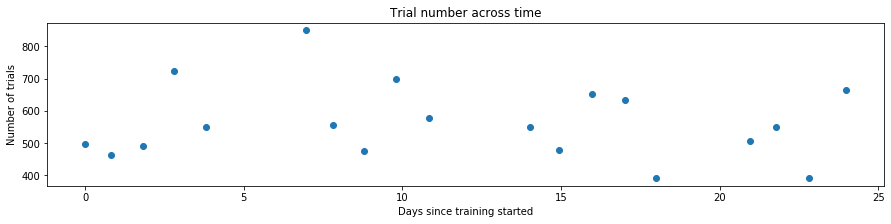

In [4]:
# make a plot that shows the number of trials done per session as a function of the training day,
# showing in different colors the data that is there, the new one, and the removed one
if update:
    # get info for the number of trials per session in the dataframe
    ntrials_df = AnimalDF.groupby('FullSessionTime').size()
    # assumes the start training day is the oldest of the dataframe
    # transform the datetime format into BpodDates
    bpod_times = [i.strftime('%Y%m%d_%H%M%S') for i in ntrials_df.index]
    # get the time differences
    df_time_differences = cuf.timeDifferences(bpod_times)

# get the time differences of the old ones (insert the 0 and then remove it)
if update:
    old_times = cuf.ParseForTimes([ntpath.basename(i) for i in old_files])
    old_times.insert(0, bpod_times[0])
    old_time_differences = cuf.timeDifferences(old_times)[1:len(old_times)]

# get the time differences of the new ones (insert the 0 and then remove it)
ExperimentDates_Raw = cuf.ParseForTimes(ExperimentFiles)
if update:
    ExperimentDates_Raw.insert(0, bpod_times[0])
    TimeDifferences = cuf.timeDifferences(ExperimentDates_Raw)[1:len(ExperimentDates_Raw)]
    ExperimentDates_Raw = ExperimentDates_Raw[1:len(ExperimentDates_Raw)]
else:
    TimeDifferences = cuf.timeDifferences(ExperimentDates_Raw)
# plot number of trials as a function of time
fig, ax = plt.subplots(figsize=(15,3))
if update:
    ax.plot(df_time_differences, ntrials_df, 'o')
    for line in old_time_differences:
        ax.axvline(line, color = 'red')
ax.plot(TimeDifferences, ntrialsDistribution, 'o', color = 'green')
plt.title('Trial number across time')
plt.ylabel('Number of trials')
plt.xlabel('Days since training started')
plt.show()

In [5]:
## OPTIONAL
# Clean new data by number of trials
# Remove those experiments for which a proper time has not been found (old ones that are missing a lot of variables)
# Or those with low number of trials
minNoOfTr = 30
idxToRemove = cuf.identifyIdx(ExperimentDates_Raw, ntrialsDistribution, minNoOfTr)

for idx in idxToRemove:
    print('deleting data for {} with {} trials'.format(ntpath.basename(ExperimentFiles[idx]), ntrialsDistribution[idx]))
    ExperimentData.pop(idx)
    ExperimentFiles.pop(idx)
    ExperimentDates_Raw.pop(idx)
    ntrialsDistribution.pop(idx)
    Protocols.pop(idx)
    Stimulations.pop(idx)
    Muscimol.pop(idx)

deleting data for D2opto-03_Two_Alternative_Choice_20211004_144437.mat with 9 trials


In [6]:
# get all data into the dataframe
# Transform experiment dates to datetime
ExperimentDates = cuf.BpodDatesToTime(ExperimentDates_Raw)
DataFrames = [cuf.SessionDataToDataFrame(AnimalID, ExpGroup, ExperimentDates[i], exp['SessionData'])
              for i, exp in enumerate(ExperimentData)]

AnimalDF_new = pd.concat(DataFrames, ignore_index=True)
if update:
    AnimalDF = pd.concat([AnimalDF, AnimalDF_new], ignore_index=True)
else:
    AnimalDF = AnimalDF_new

In [7]:
# convert some NaNs to 0s (old data not having some fields)
AnimalDF.RewardChange.fillna(0, inplace=True)
AnimalDF.RewardChangeBlock.fillna(0, inplace=True)

In [91]:

### OPTIONAL ###
# Change stuff for some sessions if they are wrong
# T03
# AnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Jun10 15:12'].index] = 'No'
# T01
#AnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Jun10 15:11'].index] = 'No'
# pdyn01
#AnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Oct11 15:09'].index] = 'NAc'
#AnimalDF.Muscimol.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec12 15:25'].index] = 'No'
# LFPo07
#AnimalDF.Stimulation.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec09 13:32'].index] = 'NoStimulation'
#AnimalDF.Stimulation.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec10 16:05'].index] = 'NoStimulation'
#AnimalDF.Stimulation.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec11 15:58'].index] = 'NoStimulation'
#AnimalDF.Stimulation.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec14 15:29'].index] = 'NoStimulation'
# LFPo08
#AnimalDF.OptoStim.iloc[AnimalDF[AnimalDF['SessionTime']=='Dec15 15:42'].index] = 0.

In [92]:
#AnimalDF = AnimalDF[AnimalDF.SessionTime != 'Feb26 10:59']

***
#### Remove experiments that are not good

In [8]:
# Select indexes to remove and remove them
expToRemove = []

IDsToRemove = [] # do not write here
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):
    if counter in expToRemove:
        print(session + ' Removed')
        IDsToRemove.append(session)

AnimalDF = AnimalDF.loc[~AnimalDF['SessionTime'].isin(IDsToRemove)]

Progress: [####################] 100.0%


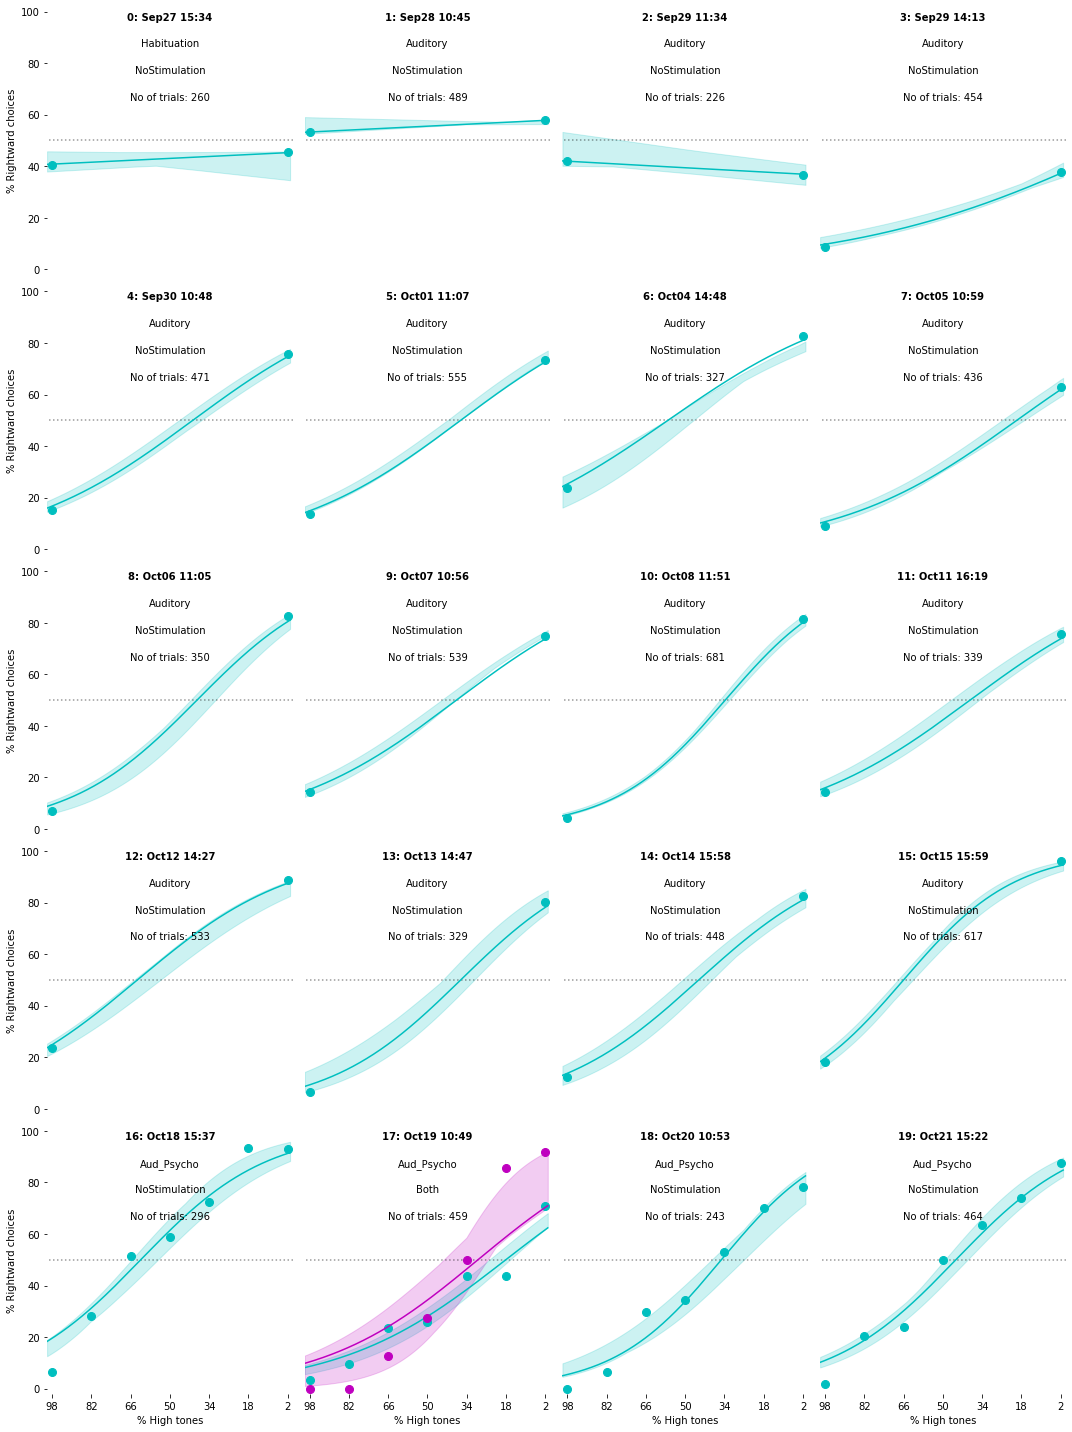

In [9]:
# Make a plot with the performance for all sessions
# generate a list of the conditions, colors and labels
CondList = [(AnimalDF['OptoStim']==0),
            (AnimalDF['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

fig, axs = plt.subplots(math.ceil(len(pd.unique(AnimalDF['SessionTime']))/4), 4,
                        figsize=(15, len(pd.unique(AnimalDF['SessionTime']))),
                        facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < len((pd.unique(AnimalDF['SessionTime']))):
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):
    ax = axs[counter]
    for i, condition in enumerate(CondList):
        predictDif, PsyPer, fakePredictions, predictPer, _ = \
        cuf.PP_ProcessExperiment(AnimalDF[(AnimalDF['SessionTime'] == session) & condition], bootstrap=5)
        if PsyPer:
            plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                            predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                            realPred =predictPer, color=ColorList[i], label=LabelList[i])
        
    ax.get_legend().remove()
    ax.text(.5,.95, str(counter) + ': ' + (session), \
                      horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
    
    axs[counter].text(.5,.85, AnimalDF[(AnimalDF['SessionTime'] == session)].Protocol.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, AnimalDF[(AnimalDF['SessionTime'] == session)].Stimulation.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.65, 'No of trials: ' + str(len(AnimalDF[(AnimalDF['SessionTime'] == session)])) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    
    #axs[counter].set_ylabel('')
    #axs[counter].set_xlabel('')
    ax.axis('on')
    # remove some ticks
    ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                   labelleft='on', labelbottom='on')
    if not ax.is_first_col():
        ax.set_ylabel('')
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xlabel('')
        ax.set_xticks([])
    plt.tight_layout()

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [10]:
# save the dataframe
AnimalDF.to_pickle(outputDir + AnimalID + '_dataframe.pkl')

***
###### Make a summary plot of the sesssions and performances

***

In [5]:
# read data like this:
AnimalDF = pd.read_pickle(outputDir + AnimalID + '_dataframe.pkl')

In [6]:
dfToPlot = plot_utils.summary_matrix(AnimalDF)

In [7]:
AnimalDF.columns

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'RewardChange',
       'RewardChangeBlock', 'CenterPortDuration', 'Contingency',
       'RewardAmount', 'PunishDelay', 'Punish', 'BiasCorrection', 'TrialIndex',
       'TrialHighPerc', 'Outcomes', 'OptoStim', 'FirstPokeCorrect',
       'FirstPoke', 'TrialSide', 'TrialSequence', 'ResponseTime',
       'TrialStartTimestamp', 'CumulativePerformance', 'SwitchSide',
       'PreviousChoice', 'TrialEvents', 'TrialStates', 'FullGUI'],
      dtype='object')

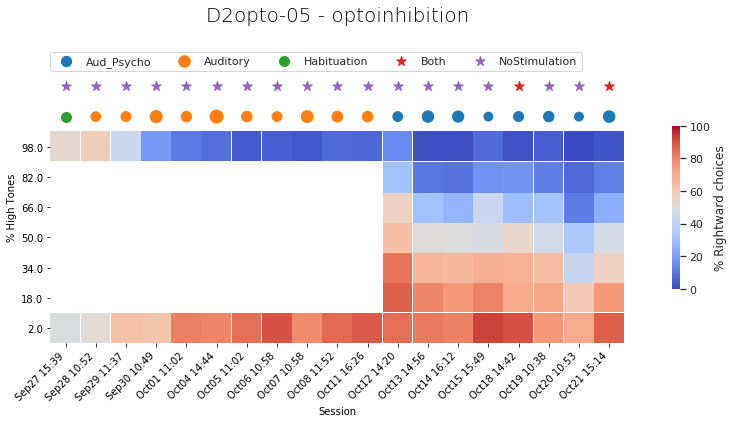

In [8]:
# plot it
fig, ax = plt.subplots(figsize=(17,5))
ax = plot_utils.summary_plot(dfToPlot, AnimalDF, ax, top_labels=['Stimulation'])
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,
            dpi = 500, bbox_inches='tight')
plt.show(fig)

***
**Plot the evolution of the cumulative performance**
***

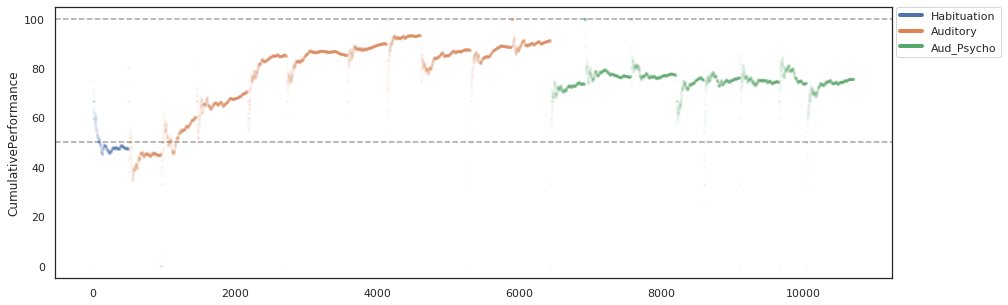

In [9]:
# TODO: include only the easy trials
# TODO: add lines to illustrate change of session
# TODO: label the sessions as above
fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x = AnimalDF.index, y = 'CumulativePerformance', data=AnimalDF, hue = 'Protocol',
             marker=".", alpha = 0.05, markeredgewidth=0, linewidth=0)
    
lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

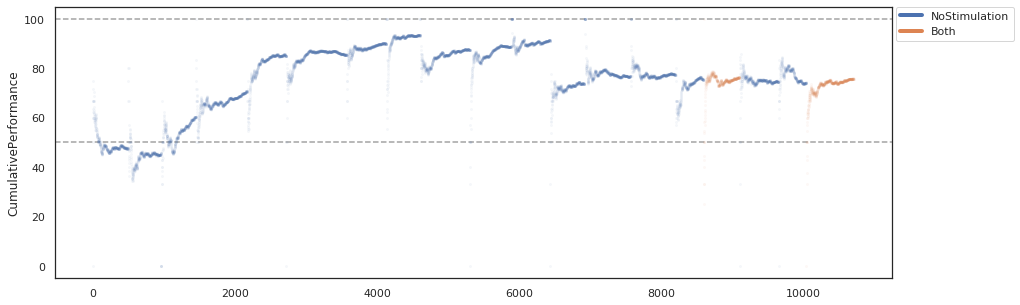

In [10]:
# TODO: include only the easy trials
# TODO: add lines to illustrate change of session
# TODO: label the sessions as above
fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x = AnimalDF.index, y = 'CumulativePerformance', data=AnimalDF, hue = 'Stimulation',
             marker=".", alpha = 0.05, markeredgewidth=0, linewidth=0)
    
lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_CumulativePerformance_Stimulation.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

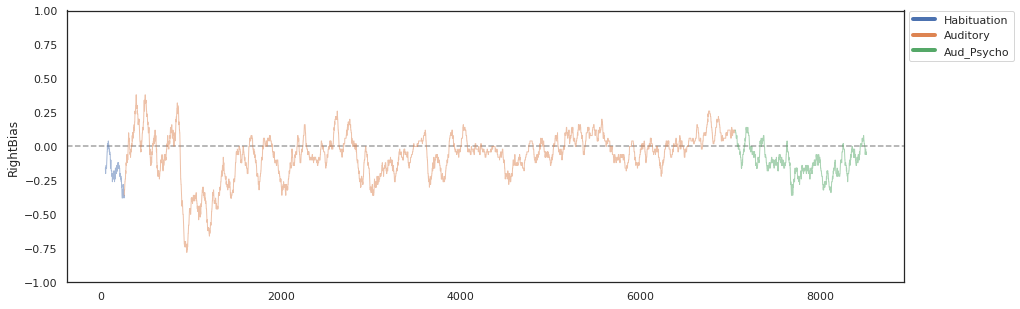

In [17]:
# plot the bias of the mouse over the sessions
AnimalDF['RightBias'] = cuf.CalculateRBiasWindow(np.array(AnimalDF['FirstPoke']),\
                                                              np.array(AnimalDF['FirstPokeCorrect']), 50)

fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(0, ls='--', alpha=0.4, color='k')
sns.lineplot(x=AnimalDF.index, y='RightBias', data=AnimalDF, hue='Protocol',
             alpha=0.5, markeredgewidth=0, linewidth=1)
ax.set(ylim=(-1,1))  
lgd = plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_RightBias.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

***
**Plot percentage correct by session, based on whether the mouse stays on the same port or switches**
***

NameError: name 'ntrialsDistribution' is not defined

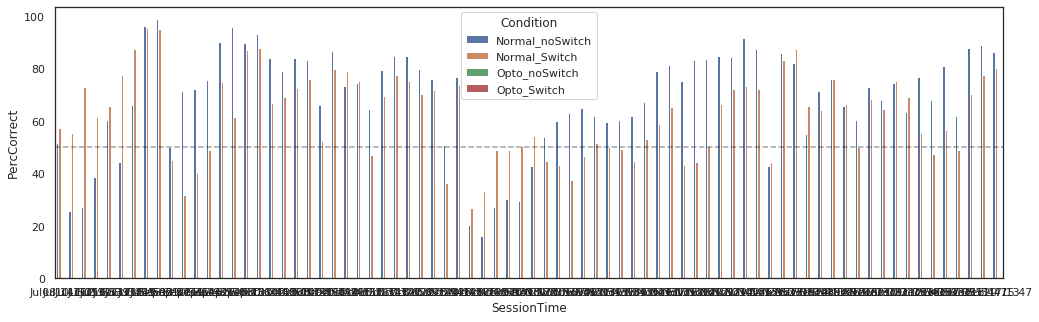

In [24]:
# Separate between trials that are ocurring in a row and those that the animal has to switch (repetitive vs new side)
dfForBP = cuf.AnalyzeSwitchTrials(AnimalDF)

fig, ax = plt.subplots(figsize=(17,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
sns.barplot(x='SessionTime', y='PercCorrect', hue='Condition', data=dfForBP)
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x for x in protIdx], np.repeat(105, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
lgd = plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)
plt.savefig(outputDir + AnimalID + '_PercCorrectBySession.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [20]:
AnimalDF.columns

Index(['AnimalID', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullSessionTime', 'Muscimol', 'OptoStim',
       'Outcomes', 'PreviousChoice', 'Protocol', 'ResponseTime',
       'RewardAmount', 'RewardChange', 'RewardChangeBlock', 'SessionTime',
       'Stimulation', 'SwitchSide', 'TrialEvents', 'TrialHighPerc',
       'TrialIndex', 'TrialSequence', 'TrialSide', 'TrialStartTimestamp',
       'TrialStates', 'RightBias'],
      dtype='object')

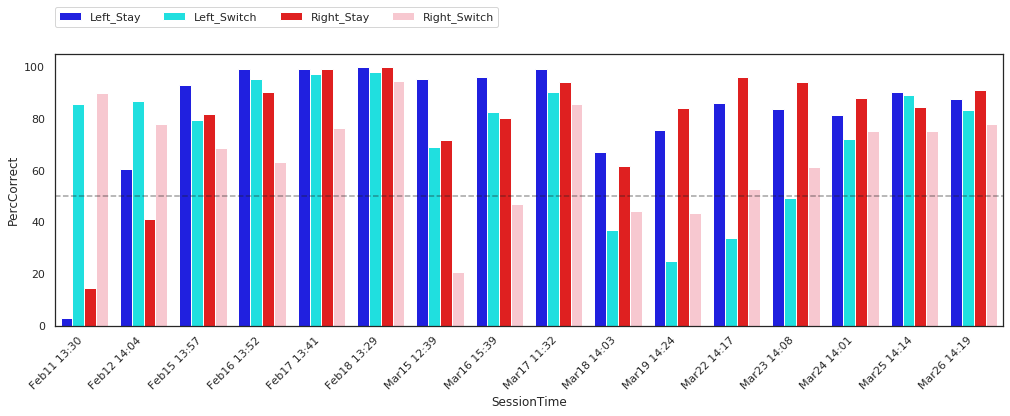

In [66]:
# select just a few sessions for the sides
selected_sessions = np.logical_and(AnimalDF.Contingency == 1, AnimalDF.Protocol.isin(['Visual', 'Auditory'])) 
dfForBP = cuf.AnalyzeSwitchTrials_for_sides(AnimalDF[selected_sessions])
fig, ax = plt.subplots(figsize=(17,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
sns.barplot(x='SessionTime', y='PercCorrect', hue='TrialSide', data=dfForBP, palette=['blue', 'cyan', 'red', 'pink'])
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
lgd = plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)
plt.savefig(outputDir + AnimalID + '_PercCorrectBySession_switch_sides.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

***
**Group sessions by type, by condition, or explore a single session**
***

In [11]:
# Group sessions by type
protToGroup = 'Aud_Psycho'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup)]

PlotsTitle = protToGroup

In [12]:
pulledData.groupby(['SessionTime', 'Stimulation']).mean()

,,RewardChangeBlock,CenterPortDuration,Contingency,RewardAmount,PunishDelay,BiasCorrection,TrialIndex,TrialHighPerc,Outcomes,OptoStim,FirstPokeCorrect,FirstPoke,TrialSide,TrialSequence,ResponseTime,TrialStartTimestamp,CumulativePerformance,SwitchSide,PreviousChoice
SessionTime,Stimulation,,,,,,,,,,,,,,,,,,,
Oct12 14:20,NoStimulation,0.0,0.25,1.0,2.0,0.0,0.0,239.5,49.300000,0.737500,0.000000,0.737500,1.606250,1.568750,4.043750,0.281449,1212.446445,71.698150,0.485417,1.605428
Oct13 14:56,NoStimulation,0.0,0.25,1.0,2.0,0.0,1.0,325.0,50.393241,0.768049,0.000000,0.768049,1.453149,1.482335,3.975422,0.250601,1428.580297,78.155617,0.493088,1.453846
Oct14 16:12,NoStimulation,0.0,0.25,1.0,2.0,0.0,1.0,316.0,49.545024,0.770932,0.000000,0.770932,1.443918,1.489731,4.028436,0.253047,1112.793517,77.924669,0.467615,1.444620
Oct15 15:49,NoStimulation,0.0,0.25,1.0,2.0,0.0,0.0,196.0,49.511450,0.753181,0.000000,0.753181,1.516539,1.432570,4.030534,0.446357,1640.557612,72.441627,0.503817,1.517857
Oct18 14:42,Both,0.0,0.25,1.0,2.0,0.0,0.0,252.5,50.284585,0.766798,0.140316,0.762376,1.471287,1.571146,3.982213,0.305387,1351.603557,74.468192,0.472332,1.472222
Oct19 10:38,NoStimulation,0.0,0.25,1.0,2.0,0.0,0.0,274.0,49.067395,0.744991,0.000000,0.744991,1.438980,1.438980,4.058288,0.238484,1180.404020,74.808987,0.480874,1.439781
Oct20 10:53,NoStimulation,0.0,0.25,1.0,2.0,0.0,0.0,195.0,49.590793,0.741688,0.000000,0.741688,1.327366,1.447570,4.025575,0.235922,671.726911,76.796232,0.516624,1.328205
Oct21 15:14,Both,0.0,0.25,1.0,2.0,0.0,0.0,332.5,49.231231,0.758258,0.142643,0.758258,1.445946,1.435435,4.048048,0.289797,1466.424129,72.695091,0.518018,1.445113


In [13]:
pulledData.SessionTime.unique()

array(['Oct12 14:20', 'Oct13 14:56', 'Oct14 16:12', 'Oct15 15:49',
       'Oct18 14:42', 'Oct19 10:38', 'Oct20 10:53', 'Oct21 15:14'],
      dtype=object)

In [135]:
#OPTIONAL
# filter for the first trials in a session
condition_initial_trials = pulledData['TrialIndex'] < 200
pulledData = pulledData[condition_initial_trials]

No handles with labels found to put in legend.


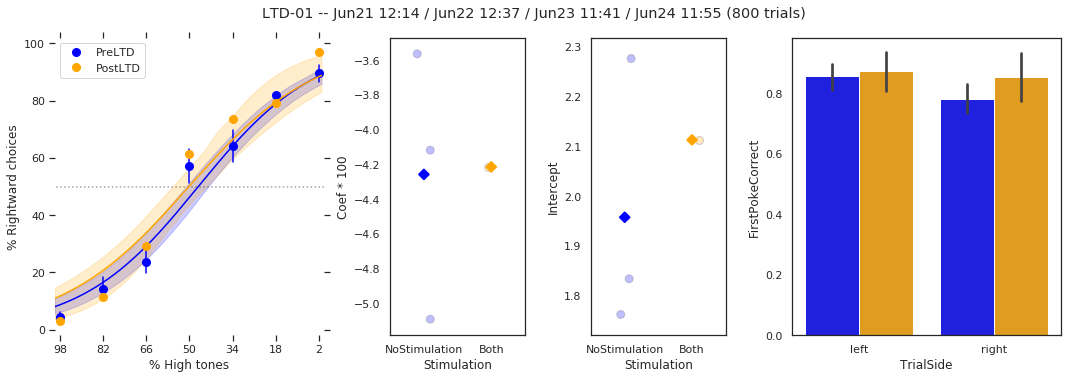

In [136]:
# compare different session types SIMPLE PLOTS
# generate a list of the conditions, colors and labels
normal_list = ['Jun21 12:14',
       'Jun22 12:37', 'Jun23 11:41']
ltd_list = ['Jun24 11:55']
#mus_list = ['Jun25 12:22']

CondList = [pulledData.SessionTime.isin(normal_list),
            pulledData.SessionTime.isin(ltd_list)]
            #pulledData.SessionTime.isin(mus_list)]


ColorList = ['blue', 'orange', 'green']
mypal = sns.xkcd_palette(ColorList)
mypal = ['blue', 'orange', 'green']
LabelList = ['PreLTD', 'PostLTD', 'Muscimol_A1']

nTrials_counter = 0

# plot
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [2, 1, 1, 2]}, figsize=(15, 5), facecolor='w', edgecolor='k')
ax = axs.ravel()


ax[0].hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], 50, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = ax[0], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
    nTrials = pulledData[condition].shape[0]
    nTrials_counter += nTrials
    
ax[0].legend(loc='upper left')
lgd = plt.legend()


### Second and Third plot. Parameters of the psychometric curve
# fit a model to each session, extract the parameters, and compare those
# select dataset
sub_df = pulledData[np.array(CondList).any(axis=0)]
# create empty df
coefs_df = pd.DataFrame(columns=['AnimalID', 'SessionID', 'Stimulation', 'Coef', 'Intercept', 'Cs'])

for session in sub_df.SessionTime.unique():
    df_sun = sub_df[sub_df.SessionTime == session]
    # calculate the psych
    predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df_sun, None)

    coefs_df = coefs_df.append({
                                'AnimalID': df_sun.AnimalID.unique()[0],
                                'SessionID': session,
                                'Stimulation': df_sun.Stimulation.unique()[0],
                                'Coef': PsyPer['Logit'].coef_[0][0] * 100,
                                'Intercept': PsyPer['Logit'].intercept_[0],
                                'Cs': PsyPer['Logit'].C_[0]
                                }, ignore_index=True)


# Show each observation with a scatterplot
for pc, col in enumerate(['Coef', 'Intercept']):
    sns.stripplot(x="Stimulation", y=col, #hue="Stimulation",
                  data=coefs_df, dodge=True, jitter=True,
                  alpha=.25, zorder=1, size=8, palette=mypal,
                  linewidth=1, ax=ax[pc+1])

    # Show the conditional means
    sns.pointplot(x="Stimulation", y=col, #hue="Stimulation",
                  data=coefs_df, dodge=.65, join=False, palette=mypal,
                  markers="D", scale=1, ci=None, ax=ax[pc+1])

# handles, labels = ax[2].get_legend_handles_labels()
# ax[2].legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
#               handletextpad=0, columnspacing=1,
#               loc="top right", ncol=3, frameon=True) 
ax[1].set(ylabel='Coef * 100')
#ax[1].set(ylim=(1.1*np.min(coefs_df.Coef), 0.9*np.max(coefs_df.Coef)))

#### 4th plot
# group correct choices
# remove 50% trials
correctdf = sub_df[~ (sub_df.TrialSequence == 4)]

sns.barplot(x='TrialSide', y='FirstPokeCorrect', hue='Stimulation', data=correctdf, ax=ax[3], n_boot=1000, palette=mypal)
plt.gca().set_xticklabels(['left', 'right'])
plt.gca().get_legend().remove()   

plt.tight_layout()


tt = plt.suptitle(AnimalID + ' -- ' + ' / '.join(normal_list+ltd_list) + ' (' + str(nTrials_counter) + ' trials)', y=1.05)

plt.savefig(outputDir + AnimalID + ' -- ' + ''.join(normal_list+ltd_list) + '_psychometricPerformance_simple.pdf',
            transparent=True, bbox_extra_artists=(lgd,tt), bbox_inches='tight')
plt.show(fig)

In [50]:
coefs_df

,AnimalID,SessionID,Stimulation,Coef,Intercept,Cs
0,LFP03,Feb15 16:15,NoStimulation,-0.033785,1.787140,0.0001
1,LFP03,Feb16 16:14,NoStimulation,-0.039261,2.381786,0.0001
2,LFP03,Feb17 15:51,NoStimulation,-0.036578,1.760122,0.0001
3,LFP03,Feb18 15:45,Both,-0.035340,1.814602,0.0001


In [14]:
# Group sessions by type
protToGroup = 'Aud_Psycho'
stimToGroup = 'Both'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Stimulation']==stimToGroup)]

PlotsTitle = protToGroup + '_' + stimToGroup

# provide an option to select by session TODO!

In [ ]:
# Select muscimol sessions and control sessions to compare to
Session_types = ['AUD1-bilat', 'AUD1-bilat-Control']
protToGroup = 'Aud_Psycho'
pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Muscimol'].isin(Session_types))]

PlotsTitle = protToGroup + '_' + ' - '.join(Session_types)

In [15]:
# Select a single session
SelectedSession = 'Oct21 15:14'
pulledData = AnimalDF[AnimalDF['SessionTime']==SelectedSession]
PlotsTitle = SelectedSession

In [ ]:
# Select multiple sessions
# For Os03 SelectedSessions = ['Apr10 15:22', 'Apr11 15:09', 'Apr16 17:25', 'Apr20 10:51', 'May01 13:11', 'May07 16:22', 'May17 13:58']
#SelectedSessions = ['Apr15 17:08', 'Apr18 13:24', 'Apr30 15:35', 'May04 13:38', 'May16 14:01']
SelectedSessions = ['Jun05 14:25', 'Jun06 15:16', 'Jun07 14:04', 'Jun10 15:12']
pulledData = AnimalDF[AnimalDF['SessionTime'].isin(SelectedSessions)]
PlotsTitle = ' - '.join(SelectedSessions)
# check that it worked
pd.unique(pulledData['SessionTime'])

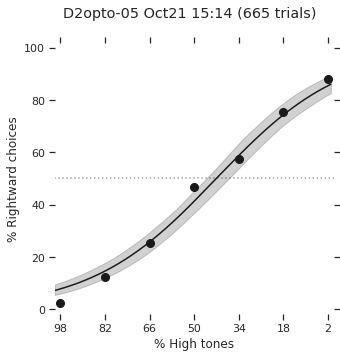

In [16]:
# simple plot
fig, axs = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
axs.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
predictDif, PsyPer, fakePredictions, predictPer, EB = \
cuf.PP_ProcessExperiment(pulledData, 100)
nTrials = max(pulledData['TrialIndex'])
if PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                 predictDif = predictDif, ax = axs, fakePred = fakePredictions,
                 realPred = predictPer, color = 'k')
axs.get_legend().remove()
plt.suptitle(AnimalID + ' ' + PlotsTitle + ' (' + str(nTrials) + ' trials)')

# plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
#             transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

In [17]:
pulledData.Stimulation.unique()

array(['Both'], dtype=object)

ValueError: Could not interpret value `RightBias` for parameter `y`

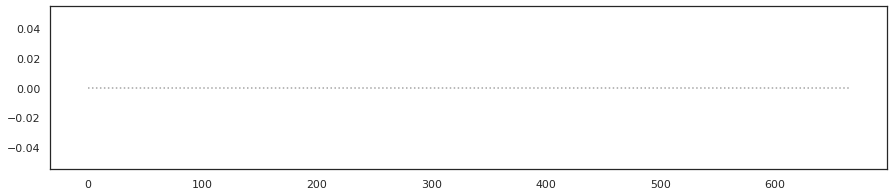

In [18]:
# Bias of the mouse
fig, axs = plt.subplots(figsize=(15, 3), facecolor='w', edgecolor='k')
axs.hlines(0, min(pulledData['TrialIndex']), max(pulledData['TrialIndex']), linestyles='dotted' , alpha=0.4)
sns.lineplot(x='TrialIndex', y='RightBias', data=pulledData,
             alpha=0.5, markeredgewidth=0, linewidth=1)

# Select break points
BreakPoints = [300, 750]
for bp in BreakPoints:
    axs.axvline(bp, color='k', alpha=0.4)
    
plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_split_trial_bias.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


In [ ]:
# Psych curves for those periods

# generate a list of the conditions, colors and labels
CondList = [(pulledData['TrialIndex'] < BreakPoints[0]),
            (pulledData['TrialIndex'] > BreakPoints[0]) & (pulledData['TrialIndex'] < BreakPoints[1]),
            (pulledData['TrialIndex'] > BreakPoints[1])]
ColorList = ['k', 'k', 'k']
LabelList = ['Beginning', 'Middle', 'End']
AxsOrder = [0,1,2]

# plot
fig, axs = plt.subplots(1,3,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_split_trial_psych.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

No handles with labels found to put in legend.


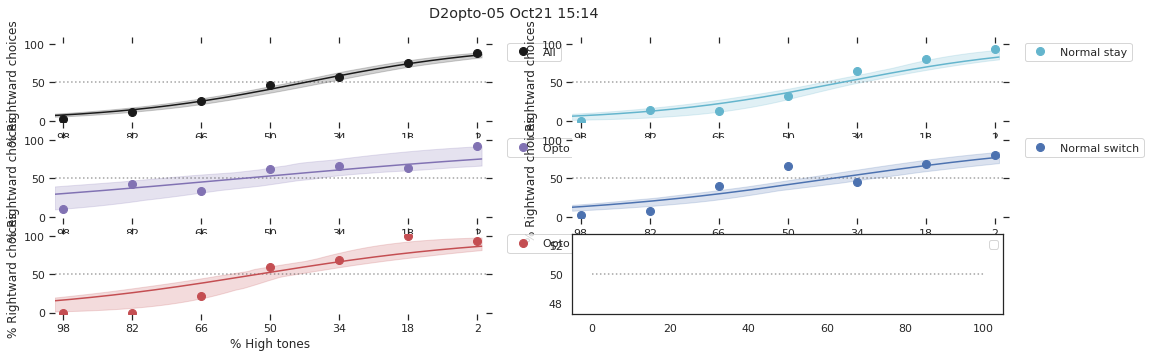

In [19]:
# plot basics about the mouse decision
# Plot differences if it the mouse has to switch, and if the previous trial was a success or not
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)

# generate a list of the conditions, colors and labels
CondList = [(pulledData['AnimalID']==AnimalID), # all data
            (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1)]
ColorList = ['k', 'c', 'm', 'b', 'r']
LabelList = ['All', 'Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,1,2,3,4]

# plot
fig, axs = plt.subplots(3,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

No handles with labels found to put in legend.


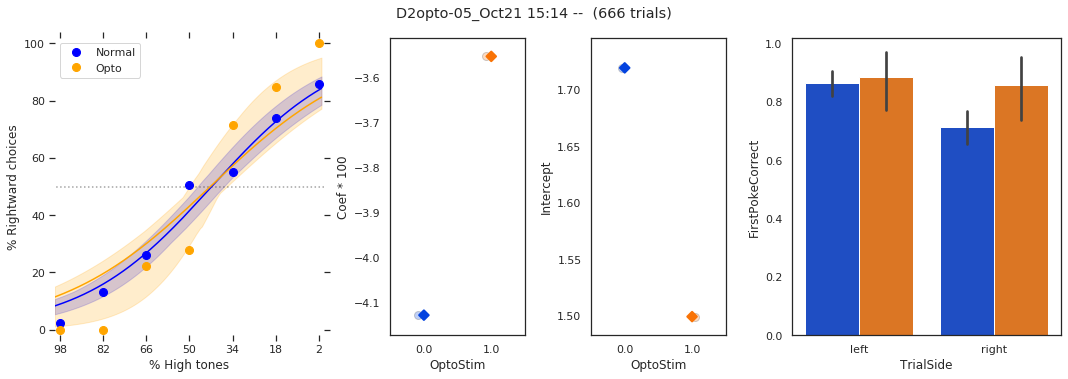

In [20]:
# compare different session types SIMPLE PLOTS
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0),
            (pulledData['OptoStim']==1)]
ColorList = ['blue', 'orange']
LabelList = ['Normal', 'Opto']


#ColorList = ['blue', 'orange', 'green']
mypal = sns.xkcd_palette(ColorList)
#mypal = ['blue', 'orange', 'green']

nTrials_counter = 0

# plot
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [2, 1, 1, 2]}, figsize=(15, 5), facecolor='w', edgecolor='k')
ax = axs.ravel()


ax[0].hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], 50, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = ax[0], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
    nTrials = pulledData[condition].shape[0]
    nTrials_counter += nTrials
    
ax[0].legend(loc='upper left')
lgd = plt.legend()


### Second and Third plot. Parameters of the psychometric curve
# fit a model to each session, extract the parameters, and compare those
# select dataset
sub_df = pulledData[np.array(CondList).any(axis=0)]
# create empty df
coefs_df = pd.DataFrame(columns=['AnimalID', 'SessionID', 'OptoStim', 'Coef', 'Intercept', 'Cs'])

for session in sub_df.SessionTime.unique():
    df_sun = sub_df[sub_df.SessionTime == session]
    CondList2 = [(df_sun['OptoStim']==0), (df_sun['OptoStim']==1)]
    for condition in CondList2:
        df_sun2 = df_sun[condition]
        # calculate the psych
        predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df_sun2, None)

        coefs_df = coefs_df.append({
                                    'AnimalID': df_sun2.AnimalID.unique()[0],
                                    'SessionID': session,
                                    'OptoStim': df_sun2.OptoStim.unique()[0],
                                    'Coef': PsyPer['Logit'].coef_[0][0] * 100,
                                    'Intercept': PsyPer['Logit'].intercept_[0],
                                    'Cs': PsyPer['Logit'].C_[0]
                                    }, ignore_index=True)


# Show each observation with a scatterplot
for pc, col in enumerate(['Coef', 'Intercept']):
    sns.stripplot(x="OptoStim", y=col, #hue="Stimulation",
                  data=coefs_df, dodge=True, jitter=True,
                  alpha=.25, zorder=1, size=8, palette=mypal,
                  linewidth=1, ax=ax[pc+1])

    # Show the conditional means
    sns.pointplot(x="OptoStim", y=col, #hue="Stimulation",
                  data=coefs_df, dodge=.65, join=False, palette=mypal,
                  markers="D", scale=1, ci=None, ax=ax[pc+1])

# handles, labels = ax[2].get_legend_handles_labels()
# ax[2].legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
#               handletextpad=0, columnspacing=1,
#               loc="top right", ncol=3, frameon=True) 
ax[1].set(ylabel='Coef * 100')
#ax[1].set(ylim=(1.1*np.min(coefs_df.Coef), 0.9*np.max(coefs_df.Coef)))

#### 4th plot
# group correct choices
# remove 50% trials
correctdf = sub_df[~ (sub_df.TrialSequence == 4)]

sns.barplot(x='TrialSide', y='FirstPokeCorrect', hue='OptoStim', data=correctdf, ax=ax[3], n_boot=1000, palette=mypal)
plt.gca().set_xticklabels(['left', 'right'])
plt.gca().get_legend().remove()   

plt.tight_layout()


tt = plt.suptitle(AnimalID + '_' + PlotsTitle + ' -- ' + ' (' + str(nTrials_counter) + ' trials)', y=1.05)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance_simple.pdf',
            transparent=True, bbox_extra_artists=(lgd,tt), bbox_inches='tight')
plt.show(fig)

In [41]:
pulledData[pulledData.OptoStim == 1].groupby(['TrialHighPerc']).count()

,AnimalID,ExperimentalGroup,SessionTime,FullSessionTime,Protocol,Stimulation,Muscimol,RewardChange,RewardChangeBlock,CenterPortDuration,...,TrialSide,TrialSequence,ResponseTime,TrialStartTimestamp,CumulativePerformance,SwitchSide,PreviousChoice,TrialEvents,TrialStates,FullGUI
TrialHighPerc,,,,,,,,,,,,,,,,,,,,,
2.0,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
18.0,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,12,13,13,13
34.0,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
50.0,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
66.0,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
82.0,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
98.0,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


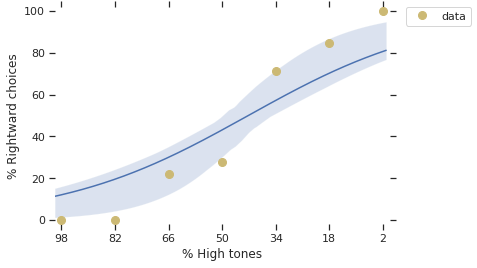

In [94]:
testdf = pulledData[pulledData.OptoStim == 1].copy()

predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(testdf, 100, error_bars='SessionTime')

plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
             predictDif = predictDif, fakePred = fakePredictions,
             realPred = predictPer, errorBars = EB)

In [47]:
predictPer

array([81.21190603, 81.18504923, 81.15816294, ..., 11.41261641,
       11.3948428 , 11.37709331])

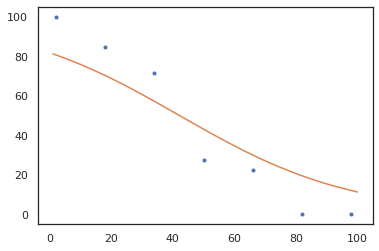

In [140]:
# REPRODUCE THIS AND IMPROVE IT
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

trialsDif = np.array(testdf['TrialHighPerc'])
sideSelected = np.array(testdf['FirstPoke'])

# masks to remove nans for logistic regression
nan_mask = ~(np.isnan(trialsDif) | np.isnan(sideSelected))
# logistic regression
clf = LogisticRegression(l1_ratio=0.5, 
                         solver='saga', penalty='elasticnet', random_state=0, max_iter=10000).fit(trialsDif[nan_mask, np.newaxis], sideSelected[nan_mask])
# Calculate performance
# Initialize values
difficulty = np.unique(trialsDif[~np.isnan(trialsDif)])
performance = np.full(len(difficulty), np.nan)
for i in range(len(difficulty)):
    if np.nansum(sideSelected[trialsDif == difficulty[i]]) > 0:
        performance[i] = 100 * (np.nanmean(sideSelected[trialsDif == difficulty[i]]) - 1)
    else:
        performance[i] = np.nan


# predict data
predictDif = np.linspace(1, 100, 100).reshape(-1, 1)
predictPer = 100 * PsyPer['Logit'].predict_proba(predictDif)[:,1]

plt.plot(difficulty, performance, '.')
plt.plot(predictDif, predictPer)



In [135]:
sideSelected

array([1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 1., 2., 2., 2., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.,
       2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 1., 1., 2., 1., 2., 2., 1., 2., 2., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1.,
       1., 1., 2., 2., 1., 1., 1., 2., 1., 2.])

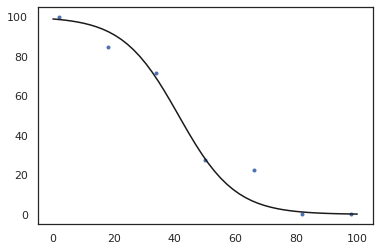

In [119]:
import scipy.optimize as opt

def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end) / (1 + np.exp(-slope * (x - bias)))

# scale the data
xdatasc = (difficulty - difficulty.mean()) / difficulty.std()
ydatasc = performance / 100

# limit to the maximum performance for this mouse:
mp = 1

cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
res = opt.minimize(cost_func, [1, 0, 0])#, bounds=((0.1, 0.9), (None,None), (None,None)))

#rescale
maximum_performance = mp * 100
slope = res.x[1] / difficulty.std()
bias = res.x[2] * difficulty.std() + difficulty.mean()

x = np.linspace(0,100)

plt.plot(difficulty, performance, '.')

sns.lineplot(x=x,
                 y=sigmoid_func(x, *[maximum_performance, slope, bias]),
                 color='k',
                 ci=None)


In [57]:
slope


-0.10823017038185004

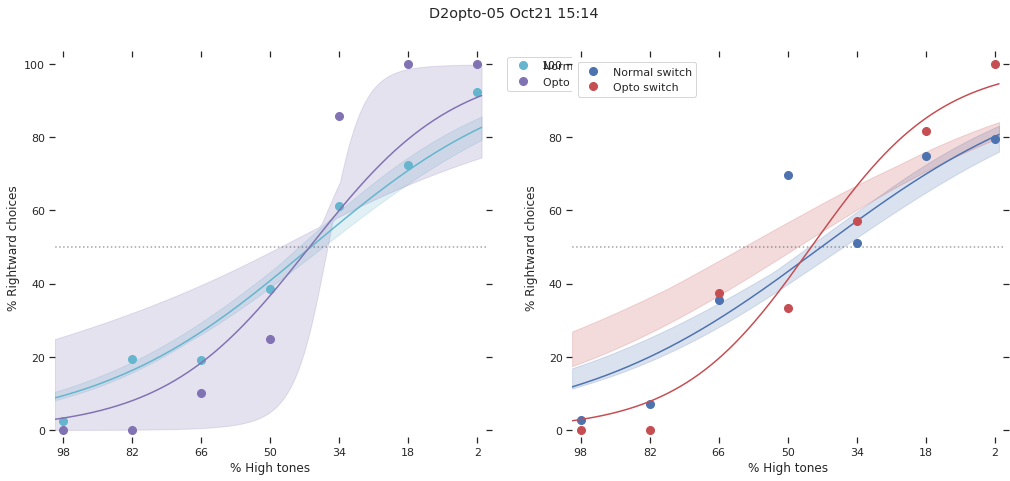

In [21]:
# plot differences between opto and normal trials if the mouse has to switch side or not
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==1)]
ColorList = ['c', 'm', 'b', 'r']
LabelList = ['Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,0,1,1]

# plot
fig, axs = plt.subplots(1,2,figsize=(17, 7), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], bootstrap=5, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

In [ ]:
# Do the same as above but select only the first X stimulation trials per session
# Create a count for the stimulation trials
CumTrialsList = []
for Sid in pd.unique(pulledData['SessionTime']):
    CumTrialsList.append(np.cumsum(pulledData[pulledData['SessionTime']==Sid]['OptoStim']))
# flatten the list of lists
pulledData['OptoStimCumulative'] = np.array(list(chain(*[x for x in CumTrialsList])))

In [ ]:
# plot
# Define the max number of stimulation trials
NST = 50
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (pulledData['SwitchSide']==0) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==0) & (pulledData['SwitchSide']==1) & (pulledData['OptoStimCumulative']<=NST),
            (pulledData['OptoStim']==1) & (pulledData['SwitchSide']==1) & (pulledData['OptoStimCumulative']<=NST)]
ColorList = ['c', 'm', 'b', 'r']
LabelList = ['Normal stay', 'Opto stay', 'Normal switch', 'Opto switch']
AxsOrder = [0,0,1,1]

# plot
fig, axs = plt.subplots(1,2,figsize=(17, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB = \
    cuf.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance_NST.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

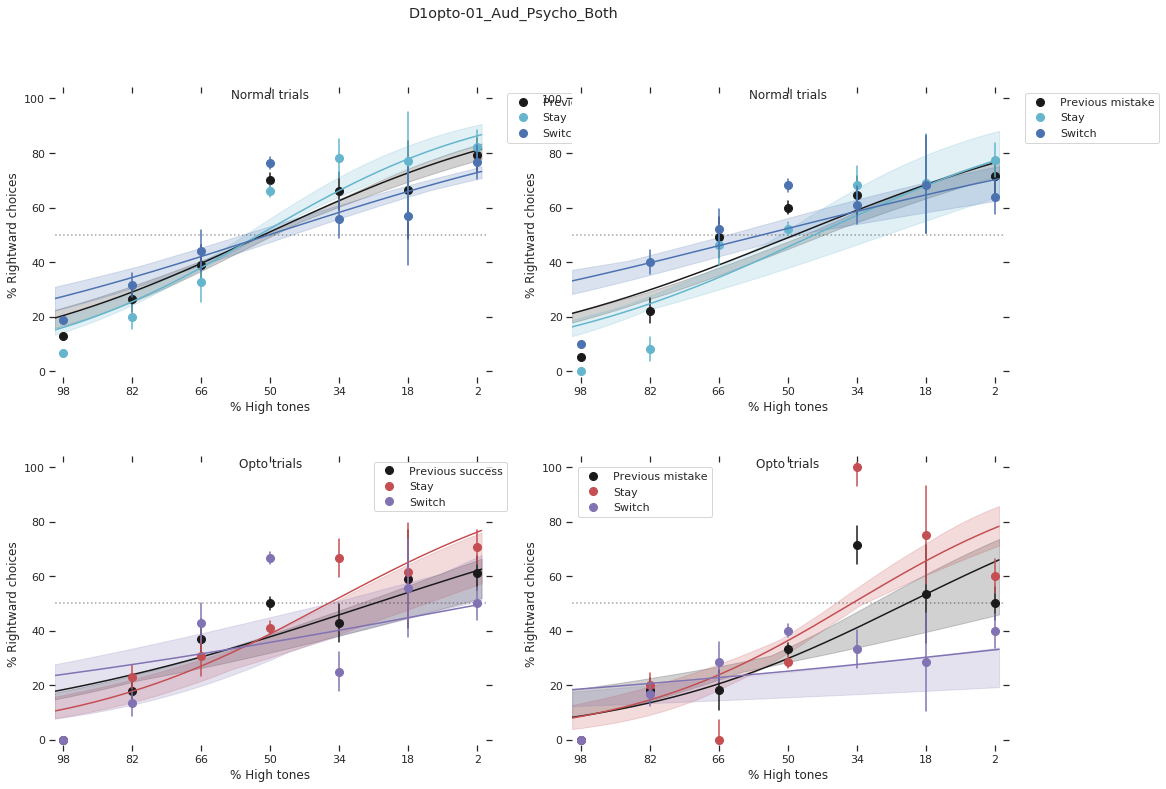

In [22]:
# Plot differences if it the mouse has to switch, and if the previous trial was a success or not
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (pulledData['SwitchSide']==1)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Stay', 'Switch', 'Previous mistake', 'Stay', 'Switch',\
             'Previous success', 'Stay', 'Switch', 'Previous mistake', 'Stay', 'Switch']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Normal trials', 'Normal trials', 'Opto trials', 'Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, _ =\
    cuf.PP_ProcessExperiment(pulledData[condition], 5)#, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + PlotsTitle)
plt.show(fig)

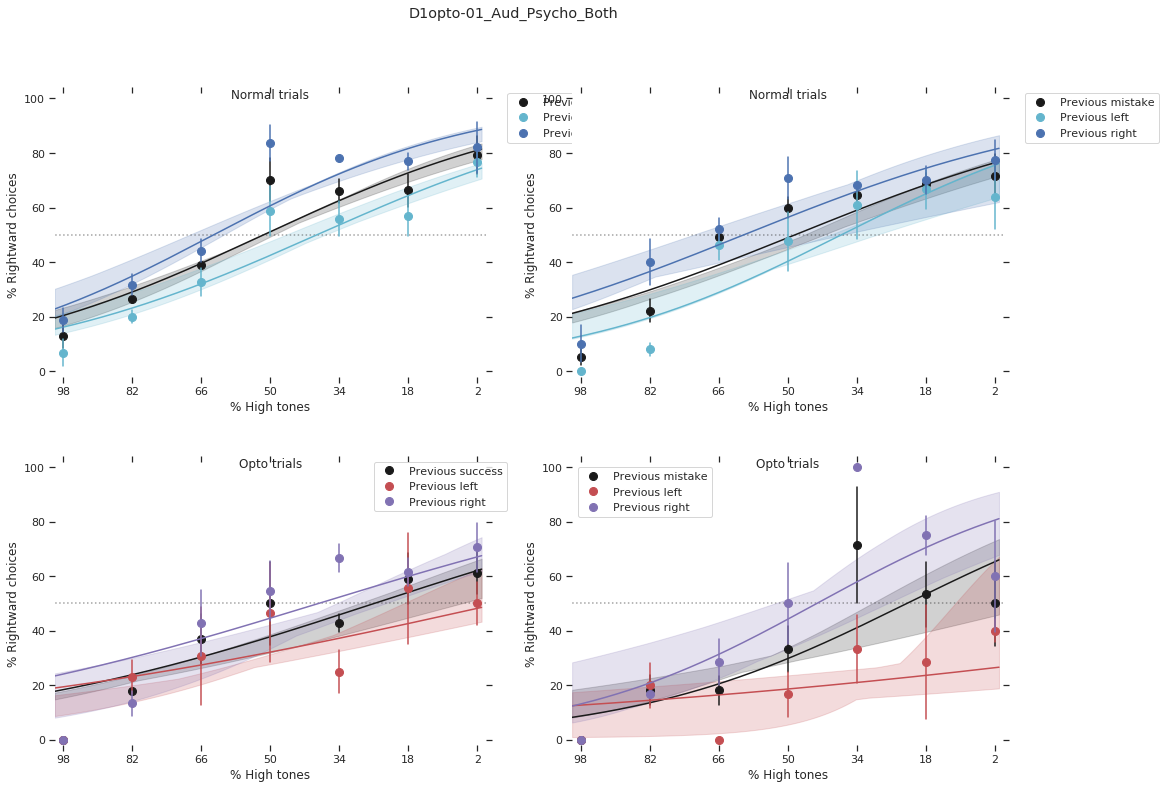

In [23]:
# Check responses to where the previous trial was (L or R) and previous success
PrevTrialSide = np.insert(np.array(pulledData['TrialSide'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(pulledData['OptoStim']==0) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (pulledData['OptoStim']==0) & (PrevTrialSuccess==0) & (PrevTrialSide==2),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (pulledData['OptoStim']==1) & (PrevTrialSuccess==0) & (PrevTrialSide==2)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right',\
             'Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Normal trials', 'Normal trials', 'Opto trials', 'Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    cuf.PP_ProcessExperiment(pulledData[condition], 5, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

In [ ]:
pulledData[condition].shape

***
**Analyze what happens during the trial**
***

In [ ]:
# Response time based on the difficulty and on whether the mouse is correct or not / optostimulation
# Number of pokes in the center

pulledData['NoOfCenterPokes'] = pulledData[['TrialEvents', 'TrialStates']].apply(cuf.CalculateMidPokes, axis=1)
pulledData['MiddleWaitTime'] = pulledData[['TrialEvents', 'TrialStates']].apply(cuf.MidPortWait, axis=1)

fig, ax = plt.subplots(3,2,figsize=(15,12))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3)
sns.barplot(x='TrialHighPerc', y='ResponseTime', hue='FirstPokeCorrect', data=pulledData, ax=ax[0])
sns.barplot(x='TrialHighPerc', y='ResponseTime', hue='OptoStim', data=pulledData, ax=ax[1])
sns.barplot(x='TrialHighPerc', y='MiddleWaitTime', hue='FirstPokeCorrect', data=pulledData, ax=ax[2])
sns.barplot(x='TrialHighPerc', y='MiddleWaitTime', hue='OptoStim', data=pulledData, ax=ax[3])
sns.barplot(x='TrialHighPerc', y='NoOfCenterPokes', hue='FirstPokeCorrect', data=pulledData, ax=ax[4])
sns.barplot(x='TrialHighPerc', y='NoOfCenterPokes', hue='OptoStim', data=pulledData, ax=ax[5])
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

In [ ]:
# plot an animated graph

# plot

# generate a list of the conditions, colors and labels
ColorList = ['r','k','r','k','r']
LabelList = ['Muscimol', 'Cortex buffer', 'Muscimol', 'Cortex buffer', 'Muscimol']

# plot
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
for i,sessionID in enumerate(pd.unique(pulledData['SessionTime'])):
    predictDif, PsyPer, fakePredictions, predictPer, _ = \
    cuf.PP_ProcessExperiment(pulledData[pulledData['SessionTime']==sessionID], 100)
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = ax, fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])
lgd = plt.legend()
plt.suptitle(AnimalID + ' ' + PlotsTitle)

plt.savefig(outputDir + AnimalID + '_' + PlotsTitle + '_psychometricPerformance_Muscimol.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

In [ ]:
pd.unique(pulledData['SessionTime'])

In [ ]:
# SEND MAXIME THE DATA FOR THE PURPLE!
SD = pulledData[(pulledData['OptoStim']==1) & (pulledData['SwitchSide']==0)]

In [ ]:
diffs = np.array(SD['TrialHighPerc'])
choices = np.array(SD['FirstPoke'])

In [ ]:
nan_mask = ~(np.isnan(diffs) | np.isnan(choices))

In [ ]:
dset = pd.DataFrame({'Difficulty': diffs[nan_mask],
                      'Choice': choices[nan_mask]})

In [ ]:
X = np.array(dset.Difficulty)
y_data = dset.groupby('Difficulty').agg(lambda x: np.mean(x == 2))
y = np.array(dset.Choice == 2)

# fit the model parameters and print optimization results
params, res = Lapse_model.fit_lapse_model(X, y)
print(res)

# display results
plt.figure()
plt.plot(y_data, 'o')
xs = np.linspace(min(X) - 0.5, max(X) + 0.5)
plt.plot(xs, Lapse_model.predict_lapse_model(xs, *params))
plt.show()


In [ ]:
res




Go step by step: DEPRECATED. Go through and fix

In [ ]:
# select a session
x = 13

In [ ]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [ ]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [ ]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

if Normal_PsyPer:
    Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
if Opto_PsyPer:
    Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

In [ ]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

if Normal_PsyPer:
    Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                    sideSelected = ExpNor['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)
if Opto_PsyPer:
    Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                    sideSelected = ExpOp['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(x) + ': ' + ExperimentTimes[x])

plt.savefig(outputDir + AnimalID + '_' + ExperimentTimes[x] + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

In [19]:
# Test to remove unengaged trials


6154

In [35]:
# Create a column that holds the ITIs
ITIs_list = []
for Sid in pd.unique(AnimalDF['SessionTime']):
    ITIs_list.append(cuf.itis_calculator(AnimalDF[AnimalDF['SessionTime']==Sid]))
# flatten the list of lists
AnimalDF['ITIs'] = np.array(list(chain(*[x for x in ITIs_list])))

Progress: [####################] 100.0%


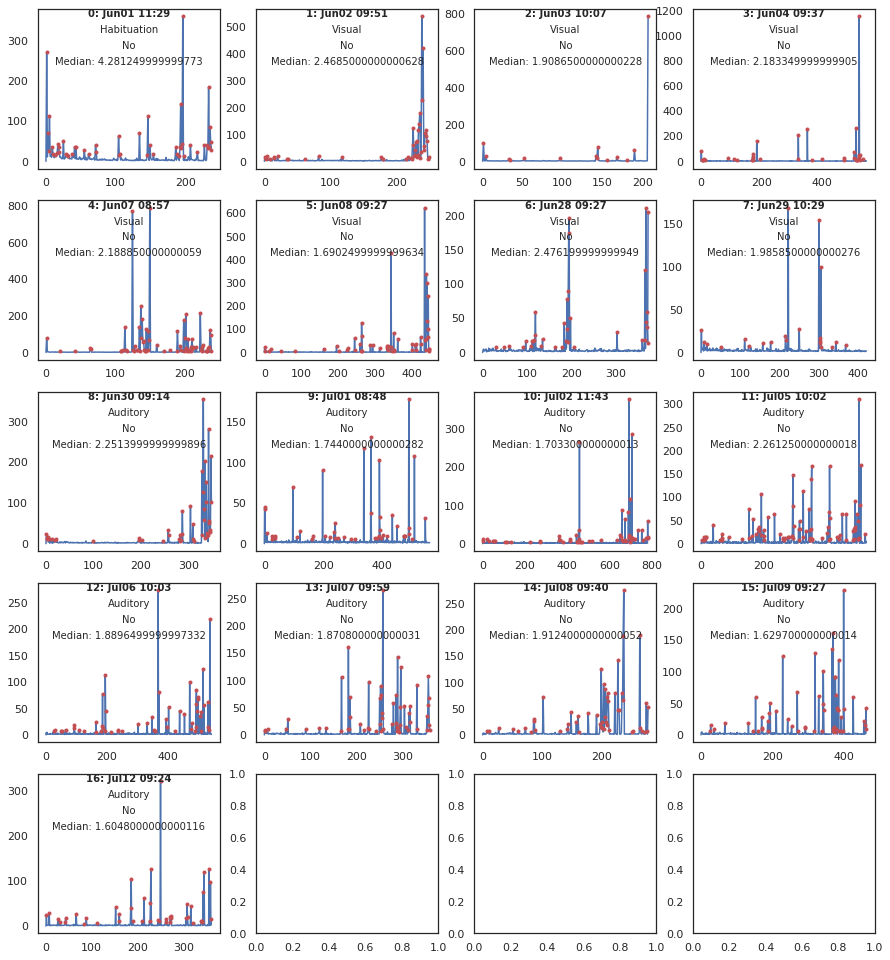

In [36]:
# list to store the indexes to remove
disengaged_global_indexes = []


fig, axs = plt.subplots(math.ceil(len(pd.unique(AnimalDF['SessionTime']))/4), 4,
                        figsize=(15, len(pd.unique(AnimalDF['SessionTime']))),
                        facecolor='w', edgecolor='k', sharey=False)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()


# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):
    ax = axs[counter]
    test_session = AnimalDF[AnimalDF.SessionTime == session]
    ax.plot(test_session.TrialIndex, test_session.ITIs)
    
    # Identify the trials where there is disengament
    dis_idx = cuf.find_disengaged_trials(test_session.ITIs)
    
    # Add them to list
    disengaged_global_indexes = disengaged_global_indexes + list(test_session.index[dis_idx])
    
    ax.plot(test_session.TrialIndex.iloc[dis_idx], test_session.ITIs.iloc[dis_idx],
            color='r', marker='.', linewidth=0)
        
    ax.text(.5,.95, str(counter) + ': ' + (session), \
                      horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
    
    axs[counter].text(.5,.85, AnimalDF[(AnimalDF['SessionTime'] == session)].Protocol.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, AnimalDF[(AnimalDF['SessionTime'] == session)].Muscimol.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.65, 'Median: ' + str(np.median(test_session.ITIs)) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    
    #axs[counter].set_ylabel('')
    #axs[counter].set_xlabel('')
    ax.axis('on')


    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)

In [28]:
# remove trials from dataframe
testdf = AnimalDF.copy()
testdf = testdf.drop(disengaged_global_indexes)

Progress: [####################] 100.0%


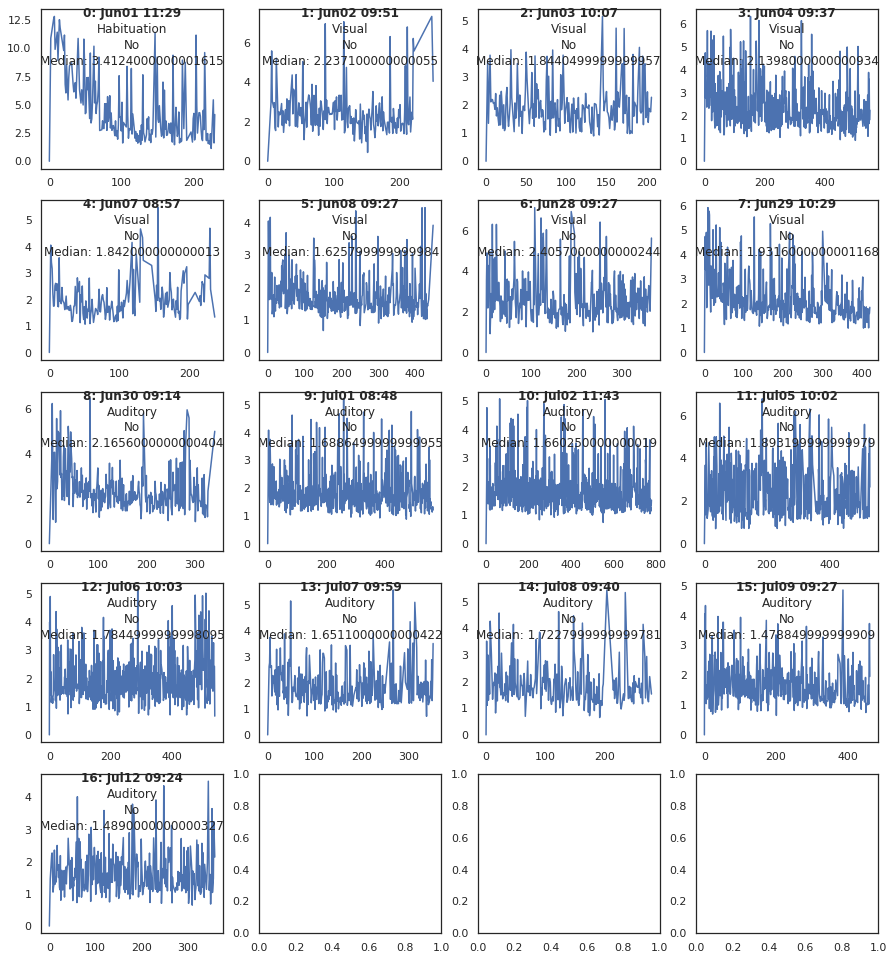

In [33]:
fig, axs = plt.subplots(math.ceil(len(pd.unique(AnimalDF['SessionTime']))/4), 4,
                        figsize=(15, len(pd.unique(AnimalDF['SessionTime']))),
                        facecolor='w', edgecolor='k', sharey=False)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

# process data from all experiments
for counter, session in enumerate(pd.unique(testdf['SessionTime'])):
    ax = axs[counter]
    test_session = testdf[testdf.SessionTime == session]
    ax.plot(test_session.TrialIndex, test_session.ITIs)
        
    ax.text(.5,.95, str(counter) + ': ' + (session), \
                      horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
    
    axs[counter].text(.5,.85, testdf[(testdf['SessionTime'] == session)].Protocol.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, testdf[(testdf['SessionTime'] == session)].Muscimol.unique()[0] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.65, 'Median: ' + str(np.median(test_session.ITIs)) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    
    #axs[counter].set_ylabel('')
    #axs[counter].set_xlabel('')
    ax.axis('on')


    update_progress(counter / len(pd.unique(testdf['SessionTime'])))
    
update_progress(1)